# fig_rq6_tpch_hudi

Plot TPCH RQ6 (Hudi only) results by order config and layout.


In [1]:
# --- Bootstrap paths so imports work both inside/outside VS Code ---
import sys
from pathlib import Path

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from viz_results_toolkit import savefig_multi

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)


In [2]:
# --- Plotting constants and loader ---

from matplotlib.patches import Patch

LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]
LAYOUT_COLORS = {
    "no_layout": "#1f77b4",
    "linear": "#ff7f0e",
    "zorder": "#2ca02c",
    "hilbert": "#d62728",
}
ORDER_RE = re.compile(r"^lineitem_orders_(.+)$")


def load_rq6_results(root_dir: Path):
    frames = []
    order_labels = []
    for order_dir in sorted(p for p in root_dir.iterdir() if p.is_dir()):
        match = ORDER_RE.match(order_dir.name)
        order_label = match.group(1) if match else order_dir.name
        if order_label not in order_labels:
            order_labels.append(order_label)
        for layout_dir in sorted(p for p in order_dir.iterdir() if p.is_dir()):
            layout = layout_dir.name
            engine_dir = layout_dir / "hudi"
            if not engine_dir.is_dir():
                continue
            for stream_dir in sorted(engine_dir.glob("stream_*")):
                ts_dirs = sorted(p for p in stream_dir.iterdir() if p.is_dir())
                if not ts_dirs:
                    continue
                latest = ts_dirs[-1]
                csv_path = latest / "results.csv"
                if not csv_path.exists():
                    continue
                df = pd.read_csv(csv_path)
                df["order_label"] = order_label
                df["layout"] = layout
                df["stream"] = stream_dir.name
                df["timestamp"] = latest.name
                frames.append(df)
    if not frames:
        raise FileNotFoundError(f"No RQ6 CSVs found under {root_dir}")
    df_all = pd.concat(frames, ignore_index=True)
    df_all["query_id"] = df_all["query"].astype(str).str.replace(".sql", "", regex=False)
    return df_all, order_labels


def prepare_rq6_stream_values(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    df = df.copy()
    df[metric] = pd.to_numeric(df[metric], errors="coerce")
    df = df.dropna(subset=[metric])
    per_stream = (
        df.groupby(["order_label", "layout", "query_id", "stream"], as_index=False)[metric]
        .mean()
    )
    return per_stream


def plot_rq6_query_grid(
    per_stream: pd.DataFrame,
    *,
    metric: str,
    layout_order=None,
    order_order=None,
    ncols=4,
    save=True,
    save_dir=None,
    filename_prefix=None,
    filename=None,
    save_formats=("png", "pdf"),
):
    layout_order = layout_order or LAYOUT_ORDER
    order_order = order_order or sorted(per_stream["order_label"].unique())
    queries = sorted(per_stream["query_id"].unique())
    n = len(queries)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows), squeeze=False)
    legend_handles = []
    seen_labels = set()

    for idx, query_id in enumerate(queries):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        dfq = per_stream[per_stream["query_id"] == query_id]
        x = np.arange(len(order_order))
        box_width = min(0.8 / max(1, len(layout_order)), 0.25)
        offsets = [(i - (len(layout_order) - 1) / 2) * box_width for i in range(len(layout_order))]

        for offset, layout in zip(offsets, layout_order):
            data = []
            for order_label in order_order:
                subset = dfq[(dfq["order_label"] == order_label) & (dfq["layout"] == layout)]
                vals = subset[metric].tolist()
                if not vals:
                    vals = [np.nan]
                data.append(vals)
            positions = x + offset
            bp = ax.boxplot(
                data,
                positions=positions,
                widths=box_width,
                patch_artist=True,
                manage_ticks=False,
                showfliers=False,
            )
            color = LAYOUT_COLORS.get(layout, "#888888")
            for patch in bp["boxes"]:
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            for median in bp["medians"]:
                median.set_color("#222222")

            if layout not in seen_labels:
                legend_handles.append(Patch(facecolor=color, edgecolor="#333333", label=layout, alpha=0.6))
                seen_labels.add(layout)

        ax.set_title(query_id)
        ax.set_xticks(x)
        ax.set_xticklabels(order_order, rotation=15, ha='right')
        ax.set_xlim(-0.5, len(order_order) - 0.5)
        ax.set_ylabel(metric)
        ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    for k in range(n, nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis('off')

    if legend_handles:
        fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc='upper center',
            bbox_to_anchor=(0.5, 0.985),
            ncol=len(legend_handles),
            frameon=False,
        )

    fig.tight_layout(rect=(0, 0, 1, 0.93))
    if save:
        base_dir = Path(save_dir) if save_dir else out_dir
        base_dir.mkdir(parents=True, exist_ok=True)
        default_prefix = f"rq6_tpch_hudi_{metric}"
        stem_value = filename or filename_prefix or default_prefix
        stem_path = Path(str(stem_value))
        base_name = stem_path.stem if stem_path.suffix else stem_path.name
        fmt_list = [stem_path.suffix.lstrip('.')] if stem_path.suffix else save_formats
        if isinstance(fmt_list, str):
            fmt_list = [fmt_list]
        saved_paths = []
        for fmt in fmt_list:
            ext = fmt.lstrip('.')
            out_path = base_dir / f"{base_name}.{ext}"
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0.02)
            saved_paths.append(out_path)
        print("saved:", ", ".join(str(p) for p in saved_paths))
    return fig


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq6_tpch_hudi_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq6_tpch_hudi_bytes_scanned_ev.pdf


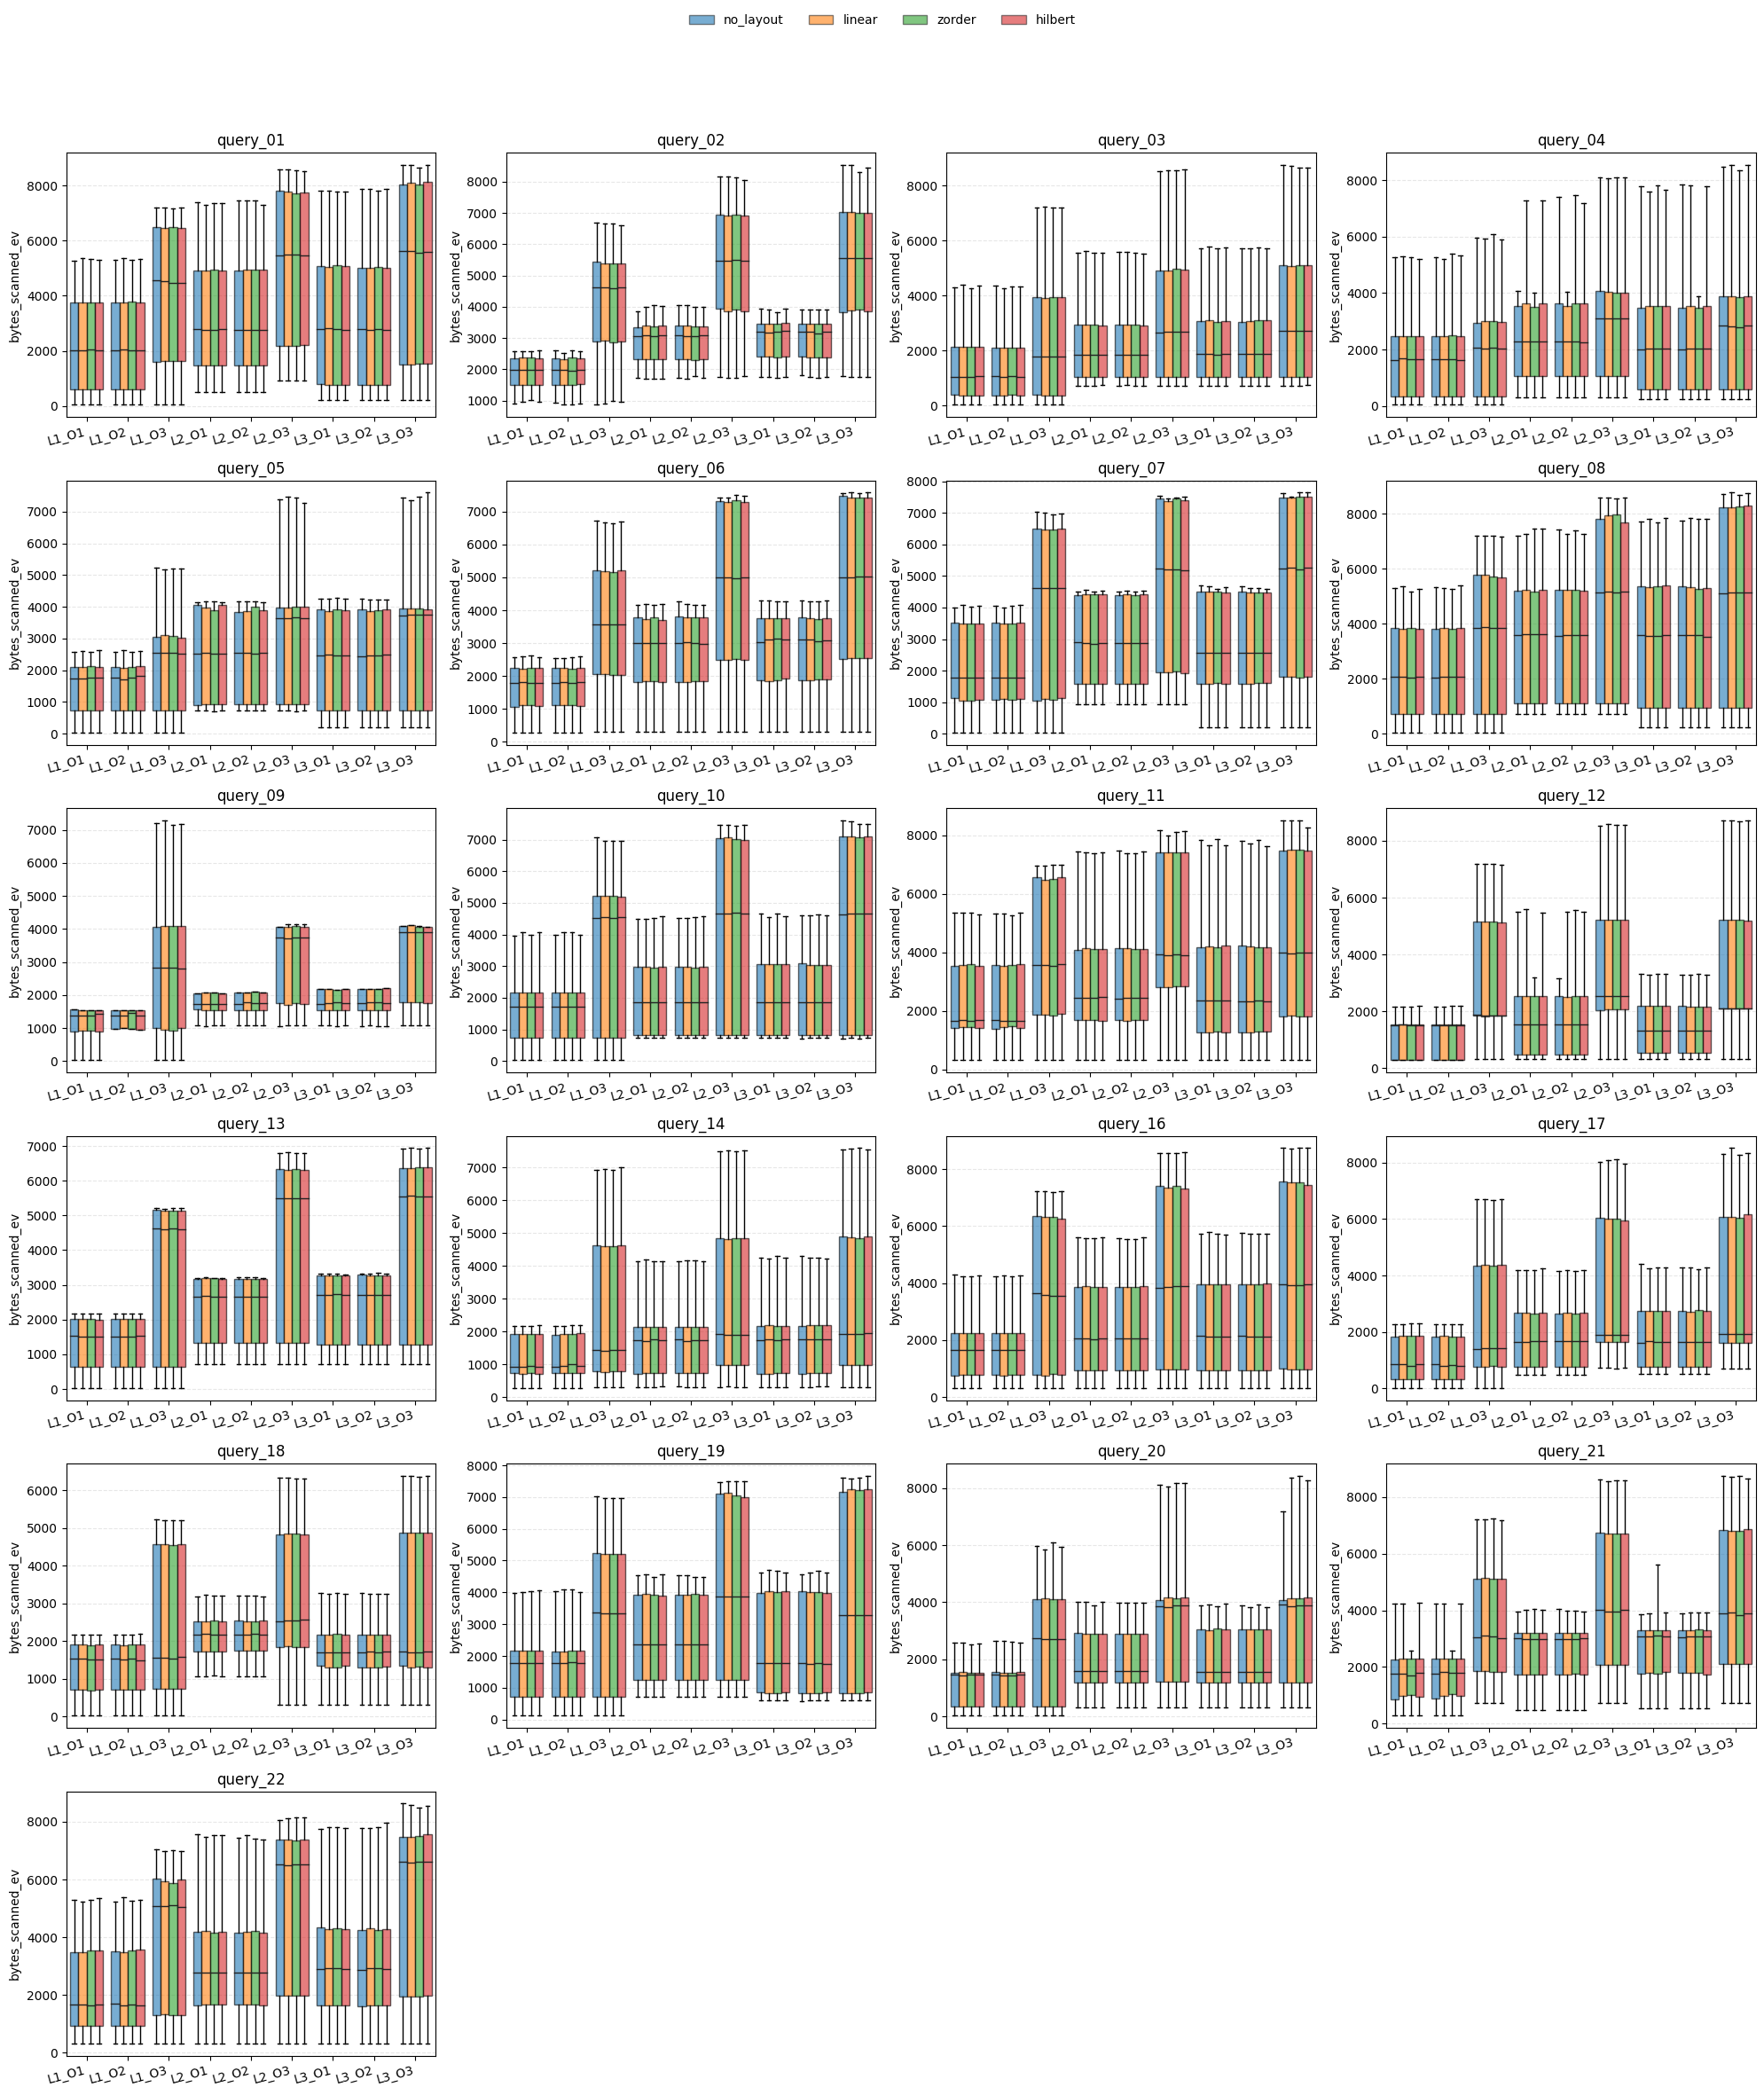

In [3]:
# Example usage: adjust metric as needed
rq6_root = PROJ_ROOT / "results" / "RQ6" / "tpch_rq6_hudi"
df_raw, order_labels = load_rq6_results(rq6_root)

metric = "bytes_scanned_ev"
per_stream = prepare_rq6_stream_values(df_raw, metric)

fig = plot_rq6_query_grid(
    per_stream,
    metric=metric,
    order_order=order_labels,
)
